## NFL Prop Model

#### Intro & motivation:
 - Build a sim model for player props that leverages air yards, target volume, and NflFastR's pre-modelled variables such as cp and yac 
 - Adjust inputs based on own research and use simulation results to place bets where value identified
 - Notion that there may be biases within prop markets that don't consider these - e.g. lot's of noise with wide reciever yardage totals - target share and air yards are more predictive than yardage totals
 - Top down approach - takes market QB attempts prop line as given

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline
from typing import List
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)
import nfl_data_py as nfl
import random

Data used from NFLFastR

In [2]:
YEARS = [2023, 2022]

data = nfl.import_pbp_data(YEARS, downcast=True, cache=False, alt_path=None)
rosters = nfl.import_seasonal_rosters(YEARS)

2023 done.
2022 done.
Downcasting floats.


In [3]:
# selecting the desired season, filter relevant plays for prop models (e.g. rushes & passes) &
# removing any erroneous rows (e.g. can't have a pass with depth of less than -15 yards)
df = data[
          (data.play_type.isin(['no_play','pass','run'])) &
          (data['epa'].isna()==False) &
          (data.air_yards > -15)
          ]

In [4]:
## using roster data to get player positions
players_df = df[(df.season.isin([2023])) & (df.play_type == 'pass')].merge(rosters[rosters.season.isin([2023])][['player_id',
                                                                                               'position']],how='left',left_on=['receiver_id'],right_on=['player_id'])

player_positions = players_df[['receiver_id','position']].drop_duplicates('receiver_id',keep='last')

The next step is to obtain a dataframe with each row denoting a single game for a player. In this row, we want to collate various stats regarding their recieving performance

In [5]:
ay_data = (
    df.groupby(['receiver','receiver_id','season','posteam','game_id','week','defteam'])
    .agg({'air_yards': 'sum', 'play_id': 'count','complete_pass': 'sum', 'yards_gained': 'sum', 'yards_after_catch': 'sum', 'cp': 'mean'})
    .reset_index()
    .sort_values(by=['air_yards'],ascending=False)
    )
ay_data

,receiver,receiver_id,season,posteam,game_id,week,defteam,air_yards,play_id,complete_pass,yards_gained,yards_after_catch,cp
1287,C.Olave,00-0037239,2022,NO,2022_02_TB_NO,2,TB,334.0,13,5.0,80.0,10.0,0.501380
2783,E.Moore,00-0036980,2023,CLE,2023_13_CLE_LA,13,LA,255.0,12,4.0,83.0,5.0,0.509561
59,A.Brown,00-0035676,2022,PHI,2022_15_PHI_CHI,15,CHI,252.0,16,9.0,181.0,65.0,0.567715
2188,D.Moore,00-0034827,2022,CAR,2022_08_CAR_ATL,8,ATL,251.0,11,6.0,152.0,32.0,0.529112
1603,D.Adams,00-0031381,2023,LV,2023_03_PIT_LV,3,PIT,240.0,20,13.0,172.0,34.0,0.670004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,K.Walker,00-0038134,2023,SEA,2023_01_LA_SEA,1,LA,-26.0,5,4.0,3.0,20.0,0.779964
161,A.Ekeler,00-0033699,2023,LAC,2023_06_DAL_LAC,6,DAL,-26.0,6,4.0,35.0,48.0,0.778293
154,A.Ekeler,00-0033699,2022,LAC,2022_14_MIA_LAC,14,MIA,-28.0,8,8.0,59.0,87.0,0.863093
170,A.Ekeler,00-0033699,2023,LAC,2023_15_LAC_LV,15,LV,-28.0,6,4.0,29.0,52.0,0.839890


Everything seems to check out here. We can see that Chris Olave saw the most air yards in a single game in the last two seasons (thanks Jameis!). Before we continue, it's worth explaining each of the relevant stats that will form the basis of the sim model!

Air yards: The distance from the yard line where the pass is thrown to the yard line where the reciever attempted to catch it. Note that I used the word "attempted"; that's because air yards are counted even on incompletions. This fact makes air yards appealing, in the sense that they may cut through some of the noise that long receptions may impart on simple yardage totals.

play_id: This is simply the sum of the targets in a given game

complete_pass: The number of completions

yards_after_catch: The number of yards the player gained after recieving a pass. Also abbreviated to "yac".

yards_gained: The total yards gained by a reciever (can also be thought of as air_yards on completed passes + yac)

cp: In this dataframe, it is the average of estimated completion probabilities over a game. NFLfastR calculates these using a machine learning framework. Other models estimating completion probability existed, with the more accurate ones leveraging next gen stats (tracking) data. However, the NGS data doesn't cover enough players to be considered here.

In [6]:
# we also want the share of receptions a player caught, as the play_id variable does not consider the amount of
# attemps a team made.
team_data = ay_data.groupby(['posteam','game_id']).agg({'play_id': 'sum'})
# to achieve this, we can obtain each team's total passes in the game, then join this onto our original dataframe
ay_data = ay_data.merge(team_data.add_suffix('_team'), how='left', on=['posteam','game_id'])

# assigning the target share variable
ay_data['target_share'] = ay_data['play_id'] / ay_data['play_id_team']
# assigning aDOT (average depth of target)
ay_data['aDOT'] = ay_data.air_yards / ay_data.play_id

let's focus on target share first, as this will form the basis of our targets prediciton. We can try to form an idea of each player's target share distribution, starting with the mean, or expected target share. Over the first five or six games of the season, simply taking the mean of a player's target share in each game may suffice. However, as the season progresses this may not be the best way to capture changes to a player's role that weren't reflected in the first few games of the season say. Thus we want to weight more recent observations differently, which can be achieved by using a decay funciton a.k.a exponential moving average.

#### Estimating decay function for target share

To optimise the right decay function (specifically the alpha in the exp. weighted mean), we can use trial and error. We use a different alpha (between 0 and 1) and use this to get an expected target share. We can then compare this to a player's actual target share to get forecast error. Whichever alpha minimises this forecast error will be used as our optimum decay value. First let's do some setup..

In [7]:
# Importantly and logically, we first need to sort values to be in chronologically order
ay_data = ay_data.sort_values(['season','week'])

# so our target share prediciton doesn't include the game we're going to be comparing it to, we need to shift
# values back one game week
ay_data['prev_ts'] = ay_data.groupby('receiver_id')['target_share'].shift()

# list of alphas to estimate. A lower alpha reflects more a lower weighting of recency.
alpha_list = np.arange(0.05,1,0.1)

#empty list to append r squared & mean abosulte error outputs
r_sqr_list = []    
mae_list = []

# statsmodels used to estimate R squared
import statsmodels.formula.api as smf

In [8]:
ay_data = ay_data.merge(player_positions,how='left',on='receiver_id')

In [9]:
# now for the for loop
for a in alpha_list:
    exp_test = ay_data.copy()
    exp_test['exp_ts'] = exp_test.groupby(['receiver_id'])['prev_ts'].apply(lambda x: x.ewm(alpha=a).mean())
    # filter out games before week 6
    # also drop any observations that have no target_share prediction (meaning it is a player's first game of the year)
    exp_test = exp_test.dropna(subset=['exp_ts'])
    
    exp_test = exp_test[(exp_test.season == 2023) & (exp_test.position == 'WR')]
    
    # estimating a simple linear regression and taking the R squared for a given alpha
    test_reg = smf.ols(formula='target_share ~ exp_ts', data=exp_test).fit()
    r_sqr = test_reg.rsquared
    r_sqr_list.append(r_sqr)
    
    # now to estimate mean absolute error.
    exp_test['abs_error'] = abs(exp_test.target_share - exp_test.exp_ts)
    mae = exp_test.abs_error.mean()
    mae_list.append(mae)
    
alpha_df = pd.DataFrame()
alpha_df['alpha'] = alpha_list
alpha_df['r_sqr'] = r_sqr_list
alpha_df['mae'] = mae_list

In [10]:
alpha_df

,alpha,r_sqr,mae
0,0.05,0.477527,0.058169
1,0.15,0.485429,0.057476
2,0.25,0.482436,0.057383
3,0.35,0.473414,0.057786
4,0.45,0.460795,0.058657
5,0.55,0.445337,0.059918
6,0.65,0.427275,0.061430
7,0.75,0.406720,0.063193
8,0.85,0.383784,0.065420
9,0.95,0.358609,0.068199


It appears that an alpha of 0.15 is most appropriate, with r_sqr maximised and mae (almost) minimised here. This reflects slightly more weighting of recency that a simple mean, indicating that target shares at the start of the season do still matter. Note that this alpha is the opitmium value no matter what the week interval is restricted to.

In [11]:
ay_data['exp_ts'] = ay_data.groupby(['receiver_id'])['prev_ts'].apply(lambda x: x.ewm(alpha=0.15).mean())

In [12]:
def get_yac_over_exp(player, teams):  
    yac_over_exp = data[data.season.isin([2022, 2023])]
    yac_over_exp['yoe'] = yac_over_exp.yards_after_catch - yac_over_exp.xyac_mean_yardage
    yac_over_exp = yac_over_exp.groupby(['receiver','receiver_id','posteam']).agg({'yoe': 'mean'}).dropna().reset_index()
    yac_over_exp = yac_over_exp[['receiver','posteam','yoe']]
    yac_over_exp = yac_over_exp[(yac_over_exp.receiver == player) & (yac_over_exp.posteam.isin(teams))].yoe.iloc[-1]

    return yac_over_exp

In [13]:
# defense specific yards after catch over average
def get_def_yac(defteam, player_pos):
    def_yac = players_df[(players_df.position.isin(['RB','WR','TE'])) & (players_df.yards_after_catch <= 15)].dropna(subset=['receiver_id']).groupby(['defteam',
                                                           'position'])[['yards_after_catch']].mean().reset_index()
    def_yac_pos = def_yac.groupby('position').yards_after_catch.mean().reset_index()
    def_yac = def_yac.merge(def_yac_pos, how='left', on='position',suffixes=['','_pos'])
    def_yac['def_yac_adj'] = def_yac.yards_after_catch - def_yac.yards_after_catch_pos
    
    def_yac = def_yac[(def_yac.defteam == defteam) & (def_yac.position == player_pos)].def_yac_adj.iloc[0]
    
    return def_yac

In [14]:
def get_def_cpoe(defteam, player_pos):
    def_cpoe = players_df[players_df.position.isin(['RB','WR','TE'])].dropna(subset=['receiver_id']).groupby(['defteam',
                                                           'position'])[['cp',
                                                                         'complete_pass']].mean().reset_index()
    def_cpoe['def_cpoe'] = def_cpoe.complete_pass - def_cpoe.cp
    def_cpoe = def_cpoe[(def_cpoe.defteam == defteam) & (def_cpoe.position == player_pos)].def_cpoe.iloc[0]
    
    return def_cpoe

In [15]:
# we want to index a cp from a team's distribution, and pre-building this as a lookup array saves a lot of time in-sim vs pandas indexing
def create_cp_lookup(data):
    
    cp_lookup = np.zeros((100, 10000))

    for air_yards in range(int(data.air_yards.min()),int(data.air_yards.max())):
        cp_condition = (data.air_yards >= (air_yards - 1.5)) & (data.air_yards <= (air_yards + 1.5))
        cp_dist = data[cp_condition].cp.to_numpy()

        cp_lookup[air_yards] = np.random.choice(a=cp_dist, size=10000)
    
    return cp_lookup

In [16]:
# Whilst trading the model I noticed one a shortcoming for recievers that would consistently overperform predicted completion pcts (e.g. Cooper
# Kupp, 2020 Robert Tonyan) so wanted to better account for this using the following function. It looks a player's completion pct over expected when
# targeted by a certain qb vs other targeted recievers by the same qb. It is then volume weighted by qb.

def get_player_catch_rate_over_expected(player, teams):
    player_pbp = data[(data.receiver == player) & (data.posteam.isin(teams))][['cp','complete_pass']]
    # if less than 50 targets, deem sample size too small
    if len(player_pbp) < 50:
        return 0
    player_pbp['cpoe'] = player_pbp.complete_pass - player_pbp.cp
    player_cpoe = player_pbp.cpoe.mean()
    
    player_passers = data[(data.receiver == player)].groupby('passer').play_id.count().reset_index()
    
    qb_cpoe_list = []
    qb_weighting = []
    for index, row in player_passers.iterrows():
        qb_df = data[(data.passer == row.passer) & (data.receiver != player)][['cp','complete_pass']]
        qb_df['cpoe'] = qb_df.complete_pass - qb_df.cp
        qb_cpoe = qb_df.cpoe.mean()
        play_weighting = row.play_id / player_passers.play_id.sum()

        qb_cpoe_list.append(qb_cpoe)
        qb_weighting.append(play_weighting)
        
    cpoe_df = pd.DataFrame({'passer':player_passers.passer, 'cpoe': qb_cpoe_list, 'qb_weighting': qb_weighting})
    cpoe_df['weighted_cpoe'] = cpoe_df.cpoe * cpoe_df.qb_weighting
    
    total_weighted_qb_cpoe = cpoe_df.weighted_cpoe.sum()
    
    final_player_cpoe = player_cpoe - total_weighted_qb_cpoe
    
    print('total player targets in sample: ' + str(len(player_pbp)))
    return final_player_cpoe

In [17]:
## using this method we would predcit Kelce's completion pct to be 6 ppts higher than expected when targeted
get_player_catch_rate_over_expected('T.Kelce', ['KC'])

total player targets in sample: 303


0.066705466220432

In [18]:
# function to provide key information for crosschecking sim output, visualisation and general observation/research on receivers
def get_player_info(player,teams,seasons):
    player_season = ay_data[(ay_data.receiver == player) & (ay_data.posteam.isin(teams)) & (ay_data.season.isin(seasons))]
    player_pbp = data[(data.receiver == player) & (data.posteam.isin(teams)) & (data.season.isin(seasons))]

    return player_season, player_season[['target_share']].apply(lambda x: x.ewm(alpha=0.15).mean()).iloc[-1].iloc[0],pd.Series(player_pbp.air_yards.dropna().to_list()).plot.hist()

In [19]:
# the sim
def get_rec_yards(years, player, team, teams, defteam, qb_dropbacks,sims,prop_line, inj_pct=0.045, output='full'):

    #indexing dataframes based on function arguments to gather contextual information for the sim
    player_season = ay_data[(ay_data.receiver == player) & (ay_data.posteam.isin(teams))]
    player_pbp = data[(data.receiver == player) & (data.posteam.isin(teams))]
    team_season = data[['air_yards','cp']].dropna()

    cp_lookup = create_cp_lookup(team_season)
    
    player_pos = players_df[(players_df.posteam.isin(teams)) & (players_df.receiver == player)].position.iloc[0]
    overall_season = data[['air_yards','yards_after_catch']].dropna().set_index('air_yards')
    # expected target share based on estimates for optimum decay value
    expected_ts = player_season[['target_share']].apply(lambda x: x.ewm(alpha=0.15).mean()).iloc[-1].iloc[0]
    
#     for manual adjustments
#     expected_ts = 0.3

    ay_dist = player_pbp.air_yards.dropna().to_list()
    ay_df = player_pbp[['air_yards','xyac_mean_yardage']].dropna()
    ay_values = ay_df[ay_df.xyac_mean_yardage > 0].values
    
    
    receiver_cpoe = get_player_catch_rate_over_expected(player, teams)
    
    # team level qb cpoe, so always keep in mind of adjustments if better qbs have missed time, etc.
    qb_cpoe = data[(data.posteam == team) & (data.season.isin(years))].cpoe.dropna().mean()
    
    # player yac over expectation
    try:
        player_yoe = get_yac_over_exp(player, teams)
    except:
        player_yoe = 0
    
    # assume player's yac over expectation is zero unless sample is large enough
    if player_season.complete_pass.sum() < 50:
        player_yoe = 0
        
    # yac over expectation allowed for defenses vs player's position group
    def_yoe = get_def_yac(defteam, player_pos)
    
    yac_adj = player_yoe + def_yoe
    
    # cp over expectation allowed for defenses vs player's position group
    def_cpoe_adj = get_def_cpoe(defteam, player_pos)

    cpoe_adj = (qb_cpoe/100) + def_cpoe_adj + receiver_cpoe
    
    long_rec_list = []
    yards_list = []
    for i in range(sims):
        # qb pass attempts (very almost) normally distributed with a SD of 8.2 attempts
        qb_drop = np.random.normal(qb_dropbacks,8.2)
        # as normal distribution will give negative/zero probabilites, distribution trncated here for accuracy
        if qb_drop < 10:
            qb_drop = 10
        # model targets as a poisson distribution with mean=variance=expected targets
        targets = np.random.poisson(expected_ts*(qb_drop))

        game_yards = 0
        game_receps_list = []
        if targets == 0:
            continue
        for i in range(targets):
            # sample depth of target from distribution
            catch = ay_values[np.random.choice(ay_values.shape[0])]
            air_yards = catch[0]
            r_number = random.randint(0, 9999)
            # sample completion probability from team's cp distribution, conditional on depth of target
            prob = cp_lookup[int(air_yards), r_number] 
            # adjust for quarterback's cpoe given cp is player agnostic
            comp_prob = prob + cpoe_adj
            
            # sample from yards after catch distribution with player specific mean adjustment
            yac = ay_values[np.random.choice(ay_values.shape[0])][1] + yac_adj
            
            # simulate outcome of target and add to current game yardage if complete
            if comp_prob < np.random.uniform():
                 game_yards += 0
            else:
                game_yards += (air_yards + yac)
                game_receps_list.append((air_yards + yac))
            
            # simulate whether player was injured between targets
            if (inj_pct / targets) > np.random.uniform():
                break
        
        # additional information to enable model to output longest reception info
        long_rec = max(game_receps_list, default=0)
        long_rec_list.append(long_rec)
        yards_list.append(game_yards)

    if output == 'full':
        print('target_share: ' + str(expected_ts))    
        print('yac_oe: ' + str(player_yoe)+' , def_yac_adj: '+ str(def_yoe)+ ' , qb_cpoe: '+ str(qb_cpoe/100)+' , def_cpoe: '+ str(def_cpoe_adj) +' , rec_cpoe: '+str(receiver_cpoe))
        return (np.median(yards_list)), (sum(i > prop_line for i in yards_list) / len(yards_list)), np.median(long_rec_list), (sum(i > 28.5 for i in long_rec_list) / len(long_rec_list))
    # for sanity checking and plotting
    elif output == 'list':
        return yards_list
    # proportion of simulations we saw total game yardage greater than given prop line
    elif output == 'pct':
         return (np.median(yards_list)), (sum(i > prop_line for i in yards_list) / len(yards_list))
    else:
        return (np.median(yards_list))

In [20]:
years = [2023]

player = 'S.Diggs'
team = 'BUF'
teams = ['BUF']
defteam = 'DAL'
passing_att = 35.5

In [21]:
# e.g. for Stefon Diggs vs the Cowboys this upcoming Sunday. Diggs exponentially weighted target share is at 28%, whilst we would expect
# Gilmore and the Dallas secondary to be strong against the pass (reflected by the -0.06 def cpoe). His yardage prop at time of writing is
# 68.5
get_rec_yards(years, player,team, teams, defteam,passing_att,20000,68.5)

total player targets in sample: 325
target_share: 0.2804182827011426
yac_oe: -0.88882333 , def_yac_adj: 0.30288982 , qb_cpoe: 0.049888138771057126 , def_cpoe: -0.06869143 , rec_cpoe: 0.02262001484632492


(71.54448986053467,
 0.5279111644657863,
 22.009925842285156,
 0.28701480592236894)

total player targets in sample: 325


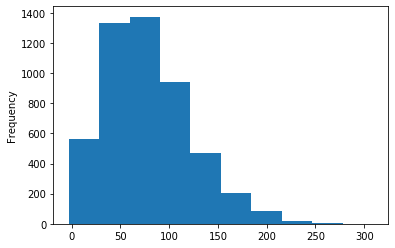

In [22]:
# The final yardage distribution.It seems to pass the eye test in terms of shape, with the customary right skew. The median is close
# to market (68.5) at 71 yards
pd.Series(get_rec_yards(years, player,team, teams, defteam,passing_att,5000,47.5, output='list')).plot.hist();

,receiver,receiver_id,season,posteam,game_id,week,defteam,air_yards,play_id,complete_pass,yards_gained,yards_after_catch,cp,play_id_team,target_share,aDOT,prev_ts,position,exp_ts
4553,S.Diggs,00-0031588,2023,BUF,2023_01_BUF_NYJ,1,NYJ,135.0,13,10.0,102.0,28.0,0.614576,39,0.333333,10.384615,0.250000,WR,0.253408
4895,S.Diggs,00-0031588,2023,BUF,2023_02_LV_BUF,2,LV,34.0,7,7.0,66.0,32.0,0.695109,36,0.194444,4.857143,0.333333,WR,0.265969
5069,S.Diggs,00-0031588,2023,BUF,2023_03_BUF_WAS,3,WAS,122.0,12,8.0,111.0,20.0,0.643882,32,0.375000,10.166667,0.194444,WR,0.254808
5330,S.Diggs,00-0031588,2023,BUF,2023_04_MIA_BUF,4,MIA,80.0,7,6.0,120.0,46.0,0.526172,25,0.280000,11.428571,0.375000,WR,0.273451
5573,S.Diggs,00-0031588,2023,BUF,2023_05_JAX_BUF,5,JAX,182.0,11,8.0,121.0,9.0,0.585392,36,0.305556,16.545455,0.280000,WR,0.274462
5809,S.Diggs,00-0031588,2023,BUF,2023_06_NYG_BUF,6,NYG,153.0,16,10.0,100.0,23.0,0.674274,29,0.551724,9.562500,0.305556,WR,0.279239
6048,S.Diggs,00-0031588,2023,BUF,2023_07_BUF_NE,7,NE,219.0,12,6.0,58.0,24.0,0.539155,39,0.307692,18.250000,0.551724,WR,0.320956
6286,S.Diggs,00-0031588,2023,BUF,2023_08_TB_BUF,8,TB,74.0,12,9.0,70.0,27.0,0.686283,39,0.307692,6.166667,0.307692,WR,0.318932
6563,S.Diggs,00-0031588,2023,BUF,2023_09_BUF_CIN,9,CIN,48.0,7,6.0,86.0,42.0,0.694474,32,0.218750,6.857143,0.307692,WR,0.317221
6831,S.Diggs,00-0031588,2023,BUF,2023_10_DEN_BUF,10,DEN,30.0,5,3.0,34.0,22.0,0.735432,25,0.200000,6.000000,0.218750,WR,0.302264


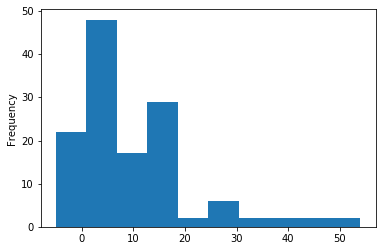

In [23]:
# contextual information for review and research purposes. Histogram is particularly useful for visualising depth of target distribution
get_player_info(player,teams,[2023])[0]

In [24]:
# for stake sizing using kelly criterion (full kelly ouput)
def get_optimal_kelly(my_pct, odds, bankroll):
    full_kelly_pct = (((odds-1)*my_pct)-(1-my_pct)) / (odds - 1)
    full_kelly_stake = bankroll * full_kelly_pct
    return full_kelly_stake

In [25]:
# for quarter kelly
get_optimal_kelly(0.58,1.905,10000) / 4

289.7790055248619

#### Some thoughts, takeaways and potential improvements:

- Needs manual adjustment - most notably with target share, as exp weighted doesn't take into account weeks where player may have left game
early/players above them in depth chart injured/ etc. This part requires vetting and manual research and can be more of an art than science
at times

- Can be thought of more as, if x player has this predicted target share against x defense, and qb throws x times, then this is their expected
yardage distribution

- Lack of backtesting: I can't find any publicly available historical player props to use for backtesting, but even if a dataset publicly
existed, a backtest may not be the most accurate due to the aforementioned manual adjustments. The results from having traded the model
against bet365 prices are positive, with a 3/4% ROI on ~300 bets over 2021/2022 seasons.

- Can definitely be refactored using OOP principles - when I first built the model I had only coded functionally. Even so there is a lot of room for improvement functionally speaking - i.e. splitting out more functions, making certain lines more concise, etc.

- YAC accuracy, model doesn't account for yard line and thus we can't accurately depicted the max yac on a play. This may have an effect if playing in games as big underdogs/favourites, where we may see expected yardline of pass play to differ to prior distribution.